In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['labels.csv', 'train', 'test', 'sample_submission.csv']


In [2]:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

     |████████████████████████████████| 122kB 601kB/s 
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54
     |████████████████████████████████| 519.5MB 69kB/s 
     |████████████████████████████████| 61kB 17.5MB/s 
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import numpy as np
import pandas as pd
import os

In [4]:
labels = pd.read_csv("../input/labels.csv")

In [5]:
!unzip test.zip

unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.


In [6]:
PATH = "../input/"
TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"

In [7]:
arch=resnet101
sz=224
bs=48

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [9]:
data = ImageClassifierData.from_csv(path=PATH, folder="train", csv_fname=f"{PATH}labels.csv", tfms=tfms, suffix=".jpg", test_name="test",bs=bs,num_workers=4)

In [10]:
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH, ps=0.4)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:05<00:00, 32699741.09it/s]


  0%|          | 0/171 [00:00<?, ?it/s]

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 216/216 [01:01<00:00,  5.27it/s]


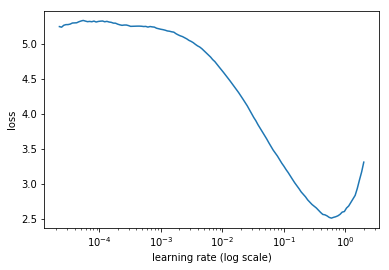

In [11]:
lrf = learn.lr_find()
learn.sched.plot()


In [12]:


def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom = 1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', suffix='.jpg',tfms=tfms, bs=bs, num_workers=4)
    return data if sz > 300 else data.resize(sz, '/tmp')



In [13]:
learn.fit(1e-1, 5)


epoch      trn_loss   val_loss   accuracy   
    0      0.776217   0.580818   0.842955  
    1      0.481209   0.461116   0.864971  
    2      0.325175   0.445951   0.877691  
    3      0.279381   0.466126   0.878669  
    4      0.220991   0.449465   0.881115  


[0.4494645646873519, 0.8811154759793366]

In [14]:
##with augmentation
learn.precompute=False
learn.fit(1e-1, 5, cycle_len=1)


epoch      trn_loss   val_loss   accuracy   
    0      0.307389   0.401771   0.889433  
    1      0.259544   0.408303   0.885029  
    2      0.258773   0.401026   0.887965  
    3      0.251281   0.40637    0.889433  
    4      0.224779   0.403939   0.887965  


[0.4039392178539194, 0.8879647943138377]

In [15]:
## increase size trick
learn.set_data(get_data(299,bs))

In [16]:
learn.fit(1e-1, 3, cycle_len=1)


epoch      trn_loss   val_loss   accuracy   
    0      0.28077    0.378057   0.896771  
    1      0.26102    0.394917   0.888943  
    2      0.235886   0.390476   0.891389  


[0.39047584480035563, 0.8913894541809471]

In [17]:
learn.fit(1e-1, 3, cycle_len=1)


epoch      trn_loss   val_loss   accuracy   
    0      0.212817   0.396944   0.894814  
    1      0.242739   0.394718   0.89726   
    2      0.201154   0.395022   0.891879  


[0.3950218358851692, 0.891878686305828]

In [18]:
learn.fit(1e-1, 3, cycle_len=1)


epoch      trn_loss   val_loss   accuracy   
    0      0.186306   0.396912   0.89726   
    1      0.195264   0.423921   0.886986  
    2      0.184973   0.414683   0.887476  


[0.41468269624355486, 0.887475560789239]

In [19]:
from sklearn.metrics import log_loss
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), log_loss(y, probs)

(0.9026418786692759, 0.352573541119717)

In [20]:
log_preds_test, y_test = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test), 0)
df = pd.DataFrame(probs_test)
df.columns = data.classes
df.insert(0, "id", [e[5:-4] for e in data.test_ds.fnames])
df.to_csv("submission.csv", index=False)